## Example 4.2: Jack’s Car Rental

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. **If Jack has a car available, he rents it out and is credited $10 by the national company**. If he is out of cars at that location, then the business is lost. **Cars become available for renting the day after they are returned**. To help ensure that cars are available where they are needed, **Jack can move them between the two locations overnight, at a cost of $2 per car moved**. We assume that **the number of cars requested and returned at each location are Poisson random variables**, meaning that the probability that the number is n is\
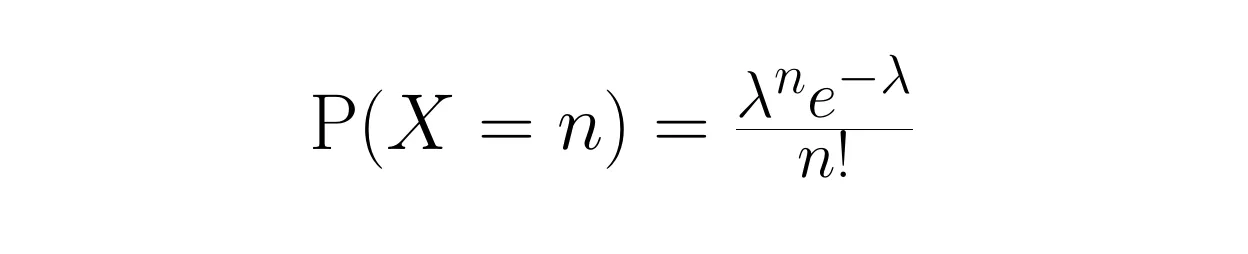
where lambda is the expected number. To simplify the problem slightly,
we assume that
- there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem)
- a maximum of five cars can be moved from one location to the other in one night.
- We take the discount rate to be gamma = 0.9


To formulate this as a continuing finite MDP:
- the `time steps` are days
- the `state` is the number of cars at each location at the end of
the day
- `actions` are the net numbers of cars moved between the two locations
overnight.

- import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np


### Define an States, Actions

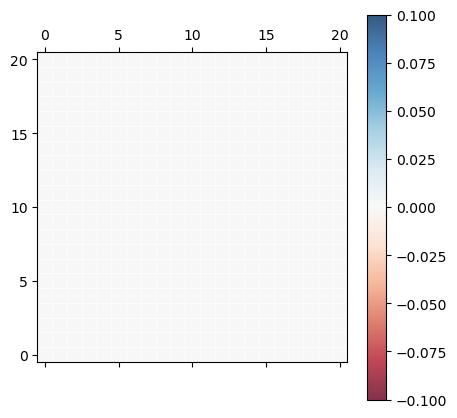

In [2]:
N_ROW = 20
N_COL = 20
STATES = {(i, j) for i in range(N_ROW+1) for j in range(N_COL+1)}
ACTIONS = {i for i in range(-5, 6)}

def plot_values(values):
    """
    Plot the values of the states in a grid.

    Parameters
    ----------
    values : dict
        A dictionary containing the values of the states. The keys are the states
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    vals = []
    for i in range(N_ROW+1):
        row = []
        for j in range(N_COL+1):
            row.append(values[(i, j)])
        vals.append(row)
    im = ax.matshow(vals, cmap="RdBu", alpha=0.8)
    for i in range(N_ROW+1):
        for j in range(N_COL+1):
            ax.plot([j-0.5, j-0.5], [i-0.5, i+0.5], c="white", linewidth=0.5)
            ax.plot([j-0.5, j+0.5], [i-0.5, i-0.5], c="white", linewidth=0.5)
    ax.invert_yaxis()
    cbar = fig.colorbar(im)
    plt.show()

values = {state:0 for state in STATES}
plot_values(values)

### Define transition

In [3]:
def transition(state, action):
    """
    Transition function for the Jack's Car Rental problem.

    Parameters
    ----------
    state : tuple
        A tuple containing the number of cars at location A and location B
    action : int
        The number of cars to move from location A to location B. If positive, the cars are moved from B to A
    
    Returns
    -------
    tuple
        A tuple containing the number of cars at location A and location B after the transition
    """

    cars_at_a = state[0] - action
    cars_at_b = state[1] + action

    if cars_at_a < 0 or cars_at_b < 0:
        return state
    
    if cars_at_a >= N_ROW:
        cars_at_a = N_ROW
    if cars_at_b >= N_COL:
        cars_at_b = N_COL
    
    return (cars_at_a, cars_at_b)
    
# Test the transition function
start_point = (3, 18)
for action in ACTIONS:
    print(start_point, action, transition(start_point, action))

(3, 18) 0 (3, 18)
(3, 18) 1 (2, 19)
(3, 18) 2 (1, 20)
(3, 18) 3 (0, 20)
(3, 18) 4 (3, 18)
(3, 18) 5 (3, 18)
(3, 18) -1 (4, 17)
(3, 18) -5 (8, 13)
(3, 18) -4 (7, 14)
(3, 18) -3 (6, 15)
(3, 18) -2 (5, 16)


### Define Reward (demand and return)

In [16]:
def poisson(n, lam):
    """
    Poisson distribution.

    Parameters
    ----------
    n : int
        number of occurrences
    lam : int
        lambda parameter

    Returns
    -------
    probability : float
        The probability of n occurrences given lambda
    """
    return np.exp(-lam) * lam**n / np.math.factorial(n)

PROBABILITIES = {}
def get_reward(state, action, values, gamma = 0.9):
    """
    Get the reward for a state-action pair.

    Parameters
    ----------
    state : set
        set of states
    action : set
        set of actions
    values : dict
        dictionary containing the values of the states
    gamma : float, optional
        discount factor, by default 0.9

    Returns
    -------
    value : float
        value of the state-action pair
    """
    epsilon = 0.001 # threshold for a small number to speed up the computation
    next_state = transition(state, action)

    value = -2 * abs(action)
    cars_at_a = next_state[0]
    cars_at_b = next_state[1]

    if next_state in PROBABILITIES:
        for p, r, s in PROBABILITIES[next_state]:
            value += p*(r + gamma*values[s])
        return value
    
    PROBABILITIES[next_state] = []
    for demand_a in range(N_ROW+1):
        p_demand_a = poisson(demand_a, 3)
        if p_demand_a < epsilon:
            continue
        if demand_a > cars_at_a:
            demand_a = cars_at_a
        for demand_b in range(N_COL+1):
            p_demand_b = poisson(demand_b, 4)
            if p_demand_b < epsilon:
                continue
            if demand_b > cars_at_b:
                demand_b = cars_at_b
            for return_a in range(N_ROW+1+5):
                p_return_a = poisson(return_a, 3)
                if p_return_a < epsilon:
                    continue
                for return_b in range(N_COL+1+5):
                    p_return_b = poisson(return_b, 2)
                    if p_return_b < epsilon:
                        continue

                    new_cars_at_a = cars_at_a - demand_a + return_a
                    new_cars_at_b = cars_at_b - demand_b + return_b
                    if new_cars_at_a < 0 or new_cars_at_b < 0:
                        continue
                    if new_cars_at_a >= N_ROW:
                        new_cars_at_a = N_ROW
                    if new_cars_at_b >= N_COL: 
                        new_cars_at_b = N_COL
                    p = p_demand_a * p_demand_b * p_return_a * p_return_b
                    reward = 10 * (demand_a + demand_b)
                    value +=  p*(reward + gamma*values[(new_cars_at_a, new_cars_at_b)])           
                    PROBABILITIES[next_state].append([p, reward, (new_cars_at_a, new_cars_at_b)])

    return value

### Define Policy and Evaluate Policy

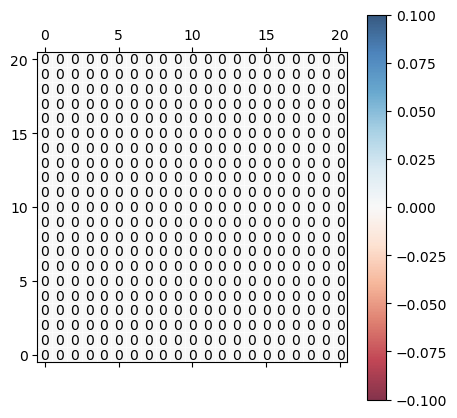

total reward:42216.420540168634	delta:165.16016890803937
total reward:80203.28498589717	delta:107.33604221903248
total reward:110161.70752468199	delta:90.06983082875462
total reward:133346.14912343468	delta:71.62970369286575
total reward:151470.41608514765	delta:54.96714232390843
total reward:165836.68905954427	delta:41.640204496539354
total reward:177347.76540885694	delta:31.88365853995242
total reward:186635.55365924077	delta:24.853688194435165
total reward:194159.89387973474	delta:19.68453659405361
total reward:200269.07903884177	delta:15.88483030829326
total reward:205234.97383937845	delta:12.915430359333868
total reward:209273.87356846643	delta:10.501307498125925


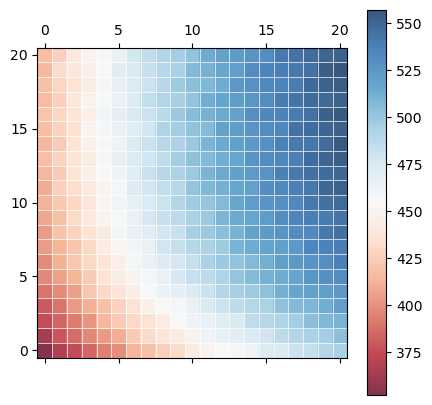

212559.74959754868


In [17]:
def policy_evaluation(values, policy, gamma = 0.9, theta = 0.001):
    """
    Evaluate a policy given the values of the states.

    Parameters
    ----------
    values : dict
        dictionary containing the values of the states
    policy : dict
        dictionary containing the policy
    gamma : float, optional
        discount factor, by default 0.9
    theta : float, optional
        theta, by default 0.1

    Returns
    -------
    values : dict
        updated dictionary containing the values of the states
    """
    while True:
        delta = 0
        i  = 0 
        n = len(STATES)
        for state in STATES:
            v = values[state]
            action = policy[state]
            values[state] = get_reward(state, action, values, gamma)
            i+=1
            print('{:.2f}: val {:.2f}'.format(i/n, values[state]), end='\r')
            delta = max(delta, abs(v - values[state]))
        if delta < theta:
            break
        print(f'total reward:{sum(values.values())}\tdelta:{delta}')
    return values

def plot_policy(policy):
    """
    Plot the policy in a grid.

    Parameters
    ----------
    policy : dict
        dictionary containing the policy. The keys are the states

    """
    
    fig, ax = plt.subplots(figsize=(5, 5))
    vals = []
    for i in range(N_ROW+1):
        row = []
        for j in range(N_COL+1):
            key = policy[(i, j)]
            row.append(key)
        vals.append(row)
    im = ax.matshow(vals, cmap="RdBu", alpha=0.8)
    for i in range(N_ROW+1):
        for j in range(N_COL+1):
            ax.plot([j-0.5, j-0.5], [i-0.5, i+0.5], c="white", linewidth=0.5)
            ax.plot([j-0.5, j+0.5], [i-0.5, i-0.5], c="white", linewidth=0.5)
            ax.text(j, i, vals[i][j], va='center', ha='center')
    ax.invert_yaxis()
    cbar = fig.colorbar(im)
    plt.show()
values = {state:0 for state in STATES}
policy = {state:0 for state in STATES}
plot_policy(policy)

values = policy_evaluation(values, policy, theta=10)
plot_values(values) 
R = sum(values.values())
print(R)


### Policy Improvements

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!5         


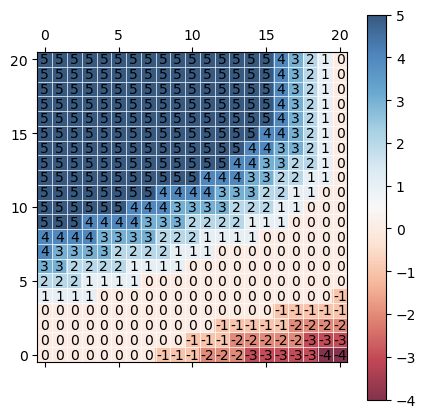

total reward:219509.75771454888	delta:60.17985631745205
total reward:222924.15572933306	delta:29.920648491769725
total reward:225320.6459302657	delta:9.246965002615411
total reward:227251.1520544582	delta:5.312424549105799
total reward:228826.1103363973	delta:4.107097456301233
total reward:230111.27983807883	delta:3.330428022101046
total reward:231158.9260807315	delta:2.7012284940451536
total reward:232012.0026704502	delta:2.1912289529048508
total reward:232705.9850288213	delta:1.7776708314766552
total reward:233270.12334429007	delta:1.4422394588842735
total reward:233728.45704441282	delta:1.170138844160931


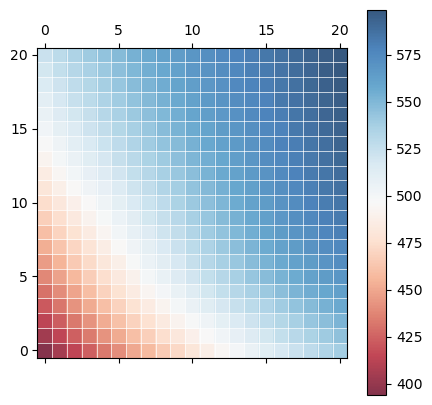

In [18]:
def policy_improvement(values, policy, gamma = 0.9):
    """
    Improve the policy given the values of the states.

    Parameters
    ----------
    values : dict
        dictionary containing the values of the states
    policy : dict
        dictionary containing the policy
    gamma : float, optional
        discount factor, by default 0.9

    Returns
    -------
    policy : dict
        updated dictionary containing the policy
    """
    
    stable = False
    counter = 0
    while not stable:
        print(f'policy iteration: {counter} ..')
        counter += 1
        stable = True
        i_counter = 0
        n = len(STATES)*len(ACTIONS)
        for state in STATES:
            best_action = None
            best_value = float("-inf")
            for action in ACTIONS:
                value = get_reward(state, action, values, gamma)
                if value > best_value:
                    best_value = value
                    best_action = action
                i_counter += 1
                print('{:.2f}: val {:.2f}         '.format(i_counter/n, value), end='\r')
            if policy[state]!=best_action:
                stable = False
            policy[state] = best_action
    print('policy updated!')  
    return policy


policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=1)
plot_values(values)

- Second iterations

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!3         


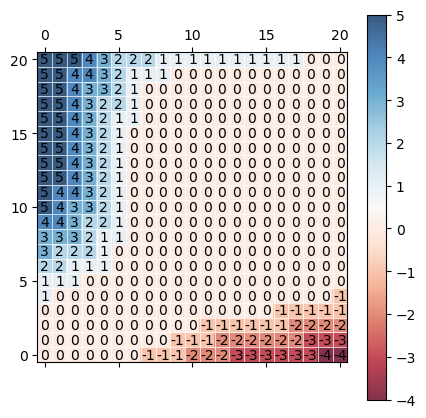

total reward:235010.61071784425	delta:5.478458917528542
total reward:235858.8392253532	delta:3.412539056566402
total reward:236526.8532584725	delta:2.6951221407997537
total reward:237025.94589314837	delta:2.0948716544297667
total reward:237395.96110351337	delta:1.6087478251882885
total reward:237672.79202147684	delta:1.188157310204133
total reward:237882.93815355963	delta:0.8577391610134555
total reward:238044.88694055082	delta:0.6151507598937087
total reward:238171.37629141513	delta:0.44334323637065154
total reward:238271.25108346774	delta:0.3237102641888896
total reward:238350.76919027796	delta:0.240542190702854
total reward:238414.46515747538	delta:0.18210579286801476
total reward:238465.7066646006	delta:0.1402604535211367
total reward:238507.05129728233	delta:0.10960057392981071


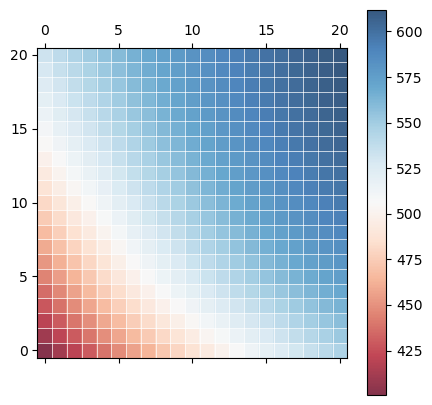

In [19]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.1)
plot_values(values)

- Third iterations 

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!1         


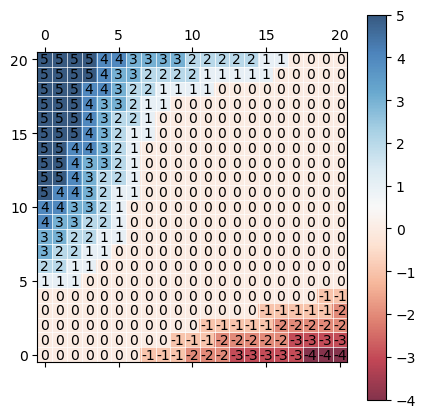

total reward:238587.08116690602	delta:0.652899815814294
total reward:238624.68135589611	delta:0.22933680633354925
total reward:238654.75738896232	delta:0.14992833951248485
total reward:238678.18606670544	delta:0.09916024018855296
total reward:238696.20435458198	delta:0.07666054696551328
total reward:238710.07091150983	delta:0.05796202336648548
total reward:238720.82673020373	delta:0.04212307965894979
total reward:238729.25345588938	delta:0.03033481275883787
total reward:238735.91721843567	delta:0.022038215034172026
total reward:238741.2268693551	delta:0.01629272313198271
total reward:238745.48172906882	delta:0.012286122342175076


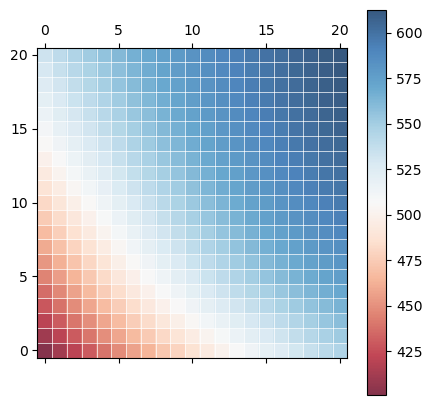

In [20]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.01)
plot_values(values)

- fourth iterations

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!6         


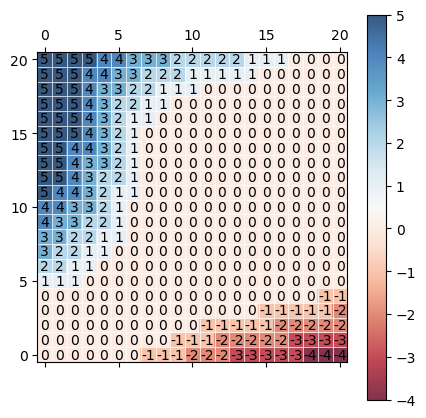

total reward:238752.06459151852	delta:0.05457466044231296
total reward:238754.611051118	delta:0.011934461619944159
total reward:238756.62704870445	delta:0.00805914244097039
total reward:238758.21872981256	delta:0.006023716769732346
total reward:238759.48024841538	delta:0.00436837570816806
total reward:238760.4855774615	delta:0.003195462017288264
total reward:238761.29082719228	delta:0.002382844781664062
total reward:238761.93843241507	delta:0.0018137283514079172
total reward:238762.46080457047	delta:0.0014055585986625374
total reward:238762.8830384018	delta:0.0011047122658283115


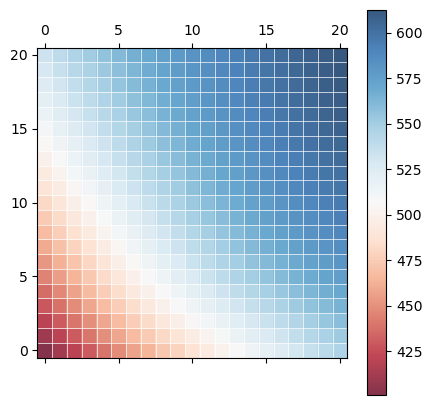

In [21]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.001)
plot_values(values)